In [1]:
import torch as tn
import torchtt as tntt
import TTCME
import matplotlib.pyplot as plt 
import datetime
import numpy as np
import pickle 
import scipy.integrate

tn.set_default_tensor_type(tn.DoubleTensor)
qtt = True

In [2]:
r1m = TTCME.ChemicalReaction(['mRNA','protein'],'mRNA->mRNA+protein', 'c1', params = ['c1'])
r2m = TTCME.ChemicalReaction(['mRNA','protein'],'mRNA->', 'c2', params = ['c2'])
r3m = TTCME.ChemicalReaction(['mRNA','protein'],'->mRNA', 'c3', params = ['c3'])
r4m = TTCME.ChemicalReaction(['mRNA','protein'],'protein->', 'c4', params = ['c4'])

mdl = TTCME.ReactionSystem(['mRNA','protein'],[r1m, r2m, r3m, r4m], params= ['c1','c2','c3','c4'])

rates = np.array([0.002,0.015,0.1,0.01])
IC = [2,4]
N = [64,64]

In [3]:
Nl = 64
mult = 2
param_range = [[0,rc*mult] for rc in rates]
basis_param = [TTCME.basis.BSplineBasis(Nl,[p[0],p[1]],deg = 2) for p in param_range]

In [4]:
p_ic = TTCME.pdf.SingularPMF(N,IC,['mRNA','protein'])
p = p_ic ** TTCME.pdf.UniformPDF(basis_param,['c1','c2','c3','c4'])
p0 = p.copy()
print(p0)

Probability density function:
p(mRNA,protein,c1,c2,c3,c4)

Basis:

DoF:
TT with sizes and ranks:
N = [64, 64, 64, 64, 64, 64]
R = [1, 1, 1, 1, 1, 1, 1]

Device: cpu, dtype: torch.float64
#entries 384 compression 5.587935447692871e-09



In [5]:
Stt, Mtt, Mtt_inv = mdl.generator_tt_galerkin(N, basis_param)
Att = Mtt_inv @ Stt


In [6]:
if qtt:
    Norig = Att.N
    A_qtt = Att.to_qtt()
    fwd_int = TTCME.TimeIntegrator.TTInt(A_qtt, epsilon = 1e-5, N_max = 8, dt_max = 1.0,method='cheby')
    pk = p0.dofs.to_qtt()
else:
    fwd_int = TTCME.TimeIntegrator.TTInt(Att, epsilon = 1e-5, N_max = 64, dt_max = 1.0,method='crank–nicolson')
    pk = p0.dofs.clone()

In [7]:
dt = 8
Nt = 32
time = Nt*dt
for k in range(Nt):
    
    pk = fwd_int.solve(pk, dt, intervals = 2,qtt = qtt,verb = False, rounding=True)
    p.dofs = tntt.reshape(pk, Norig) if qtt else pk.clone()
    
    print('Interval ',k+1,' done')

Interval  1  done
Interval  2  done
Interval  3  done
Interval  4  done
Interval  5  done
Interval  6  done
Interval  7  done
Interval  8  done
Interval  9  done
Interval  10  done
Interval  11  done
Interval  12  done
Interval  13  done
Interval  14  done
Interval  15  done
Interval  16  done
Interval  17  done
Interval  18  done
Interval  19  done
Interval  20  done
Interval  21  done
Interval  22  done
Interval  23  done
Interval  24  done
Interval  25  done
Interval  26  done
Interval  27  done
Interval  28  done
Interval  29  done
Interval  30  done
Interval  31  done
Interval  32  done


In [8]:
Asp = mdl.generator_sparse(N, rates)

res = scipy.integrate.solve_ivp(lambda t,y: Asp.dot(y), [0,time],p_ic.dofs.numpy().flatten(),max_step=time/10000)
Pt = res.y.reshape(N+[-1])
p_ref = Pt[:,:,-1]

Text(0, 0.5, '$x_2$')

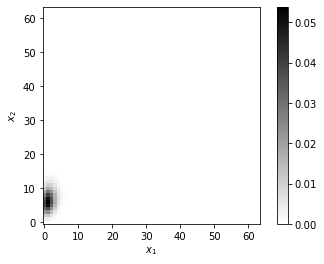

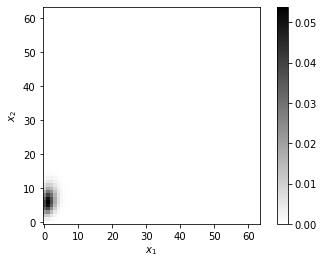

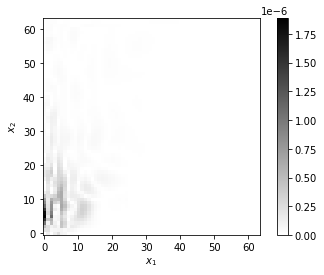

In [9]:
pend = p[np.arange(N[0]), np.arange(N[1]), rates[0], rates[1], rates[2], rates[3]]
pend = pend / pend.sum()
pend = pend.numpy().squeeze()

plt.figure()
plt.imshow(pend, origin='lower',cmap='gray_r')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.figure()
plt.imshow(p_ref, origin='lower',cmap='gray_r')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')

plt.figure()
plt.imshow(np.abs(pend-p_ref), origin='lower',cmap='gray_r')
plt.colorbar()
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')